In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import wandb

In [3]:
# Get train run IDs and get labels

api = wandb.Api()
entity, project = "psotoarenas", "RL-scalers-conf"

runs = api.runs(entity + "/" + project)
dict_labels = {}
for run in runs:
    if run.state == "finished" and run.config['mode'] == "train":
        if run.config['w_adp'] == 0. and run.config['timesteps'] == 259200:            
            # the labels are going to be configuration of weights used during training.
            label = f"w_perf:{run.config['w_perf']}, w_res:{run.config['w_res']}, w_adp:{run.config['w_adp']}"
            dict_labels[run.id] = label
print(dict_labels)
len(dict_labels)       

{'wpvidr37': 'w_perf:0.01, w_res:0.99, w_adp:0', '19ml8kbt': 'w_perf:0.01, w_res:0.99, w_adp:0', 'rvfm8jbx': 'w_perf:0.01, w_res:0.99, w_adp:0', '17b5ngb3': 'w_perf:0.01, w_res:0.99, w_adp:0', '1m7im95y': 'w_perf:0.01, w_res:0.99, w_adp:0', 'xd6gnw37': 'w_perf:0.99, w_res:0.01, w_adp:0', '81doo7an': 'w_perf:0.99, w_res:0.01, w_adp:0', '19fjlx38': 'w_perf:0.99, w_res:0.01, w_adp:0', 'j2r6hml4': 'w_perf:0.99, w_res:0.01, w_adp:0', '26j4yuvm': 'w_perf:0.99, w_res:0.01, w_adp:0'}


10

In [4]:
# Get test run traces to compute pareto 

api = wandb.Api()
entity, project = "psotoarenas", "RL-scalers-conf"

runs = api.runs(entity + "/" + project)
for run in runs:
    if run.state == "finished" and run.config['mode'] == "test":
        train_run_id = run.config["run_id"].split('/')[-1]
        if train_run_id in dict_labels.keys():
            label = dict_labels[train_run_id]
            name = f"{label}_{run.id}.traces"
            print(name)
            root = "./logs/"
            for file in run.files():
                if file.name.startswith("python") and file.name.endswith("traces"):
                    logs = file.name
                    print(f"Logs found with name {logs}")
            if not logs:
                logs = "output.log"
                print(f"No logs found. Downloading default logs {logs}")
            run.file(logs).download(root=root, replace=True)
            log_old_filename = os.path.join(root, logs)
            log_new_filename = os.path.join(root, name)
            print(f"Saving test logfile to {log_new_filename}")
            os.rename(log_old_filename, log_new_filename)
            
            

w_perf:0.01, w_res:0.99, w_adp:0_12bl5n0j.traces
Logs found with name python-20220403-201206.traces
Saving test logfile to ./logs/w_perf:0.01, w_res:0.99, w_adp:0_12bl5n0j.traces
w_perf:0.01, w_res:0.99, w_adp:0_1nx9qe7p.traces
Logs found with name python-20220403-172842.traces
Saving test logfile to ./logs/w_perf:0.01, w_res:0.99, w_adp:0_1nx9qe7p.traces
w_perf:0.01, w_res:0.99, w_adp:0_ssn95t6g.traces
Logs found with name python-20220402-235840.traces
Saving test logfile to ./logs/w_perf:0.01, w_res:0.99, w_adp:0_ssn95t6g.traces
w_perf:0.01, w_res:0.99, w_adp:0_3u5j4y9d.traces
Logs found with name python-20220402-213902.traces
Saving test logfile to ./logs/w_perf:0.01, w_res:0.99, w_adp:0_3u5j4y9d.traces
w_perf:0.01, w_res:0.99, w_adp:0_1ctjdequ.traces
Logs found with name python-20220402-185010.traces
Saving test logfile to ./logs/w_perf:0.01, w_res:0.99, w_adp:0_1ctjdequ.traces
w_perf:0.99, w_res:0.01, w_adp:0_chr0h9sj.traces
Logs found with name python-20220402-175406.traces
Savin

In [5]:
# auxiliary data for parse results
def parse_results(traces_filename, label):
    ms = []
    peak_latency = []
    labels = []
    with open(traces_filename) as f:
        current_step = 0
        cumulative_reward = 0
        for line in f:
            try:
                line = line.rstrip().split("|")[-1]
                if line.startswith("MS"):
                    ms.append(int(line.split(":")[-1].rstrip()))
                    labels.append(label)
                if line.startswith("Peak Latency"):
                    peak_latency.append(float(line.split(":")[-1].rstrip()))
            except:
                print(line)
    return ms, peak_latency, labels

In [6]:
root_folder = "./logs"
# os.chdir(root_folder)
files = [f for f in os.listdir(root_folder) if f.endswith("traces")]
# print(files)
vnfs = []
delay = []
labels = []
dict_labels = {}
conf = 1
for f in files:
    print(f)
    filename = os.path.join(root_folder, f)
    label = f.split("_")[:-1]
    label = "_".join(label)
    dict_labels[conf] = label
    ms, peak_latency, lbls = parse_results(filename, conf)
    print(len(ms), len(peak_latency), len(lbls))
    vnfs.extend(ms)
    delay.extend(peak_latency) 
    labels.extend(lbls)
    conf +=1
data = {"CPU": vnfs, "Latency": delay, "Conf": labels}

w_perf:0.01, w_res:0.99, w_adp:0_1ctjdequ.traces
172801 172801 172801
w_perf:0.99, w_res:0.01, w_adp:0_m6xl7uld.traces
173006 173006 173006
w_perf:0.99, w_res:0.01, w_adp:0_2we2ejoi.traces
172801 172801 172801
w_perf:0.99, w_res:0.01, w_adp:0_chr0h9sj.traces
172801 172801 172801
w_perf:0.99, w_res:0.01, w_adp:0_1mbns79q.traces
172801 172801 172801
w_perf:0.01, w_res:0.99, w_adp:0_12bl5n0j.traces
172801 172801 172801
w_perf:0.01, w_res:0.99, w_adp:0_3u5j4y9d.traces
172801 172801 172801
w_perf:0.01, w_res:0.99, w_adp:0_ssn95t6g.traces
172801 172801 172801
w_perf:0.01, w_res:0.99, w_adp:0_1nx9qe7p.traces
172801 172801 172801
w_perf:0.99, w_res:0.01, w_adp:0_5a3eu0vl.traces
172801 172801 172801


In [7]:
df = pd.DataFrame.from_dict(data)
max_latency = 0.024
df['Violation'] = np.where(df['Latency']>max_latency, 1, 0)
dataframe = df.groupby(['Conf'], as_index=False)
dataframe["Violation"].sum()/172800
mean_cpu_delay_per_conf = dataframe.mean()
print(dict_labels)
mean_cpu_delay_per_conf

{1: 'w_perf:0.01, w_res:0.99, w_adp:0', 2: 'w_perf:0.99, w_res:0.01, w_adp:0', 3: 'w_perf:0.99, w_res:0.01, w_adp:0', 4: 'w_perf:0.99, w_res:0.01, w_adp:0', 5: 'w_perf:0.99, w_res:0.01, w_adp:0', 6: 'w_perf:0.01, w_res:0.99, w_adp:0', 7: 'w_perf:0.01, w_res:0.99, w_adp:0', 8: 'w_perf:0.01, w_res:0.99, w_adp:0', 9: 'w_perf:0.01, w_res:0.99, w_adp:0', 10: 'w_perf:0.99, w_res:0.01, w_adp:0'}


,Conf,CPU,Latency,Violation
0,1,4.030416,0.050587,0.775221
1,2,11.174433,0.007029,0.007728
2,3,6.851523,0.007785,0.000023
3,4,4.943316,0.009595,0.002685
4,5,5.912049,0.008289,0.000046
5,6,4.027095,0.071493,0.890440
6,7,4.075532,0.032770,0.503822
7,8,4.025555,0.052406,0.777617
8,9,4.042384,0.041737,0.751523
9,10,4.369876,0.016324,0.157916


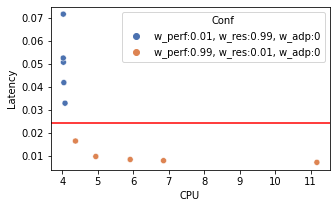

In [8]:
plot_labels = list(dict_labels.values())
fig, ax = plt.subplots(figsize=(5, 3))
ax = sns.scatterplot(data=mean_cpu_delay_per_conf, x="CPU", y="Latency", hue=plot_labels, palette="deep")
plt.axhline(y=0.024, color='r', linestyle='-')
ax.legend(loc='best', bbox_to_anchor=(1.0, 1.0), title="Conf")
plt.savefig('./pareto_lat_vnf.png', dpi=300, bbox_inches="tight")
plt.show()

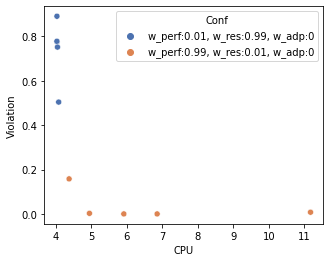

In [9]:
plot_labels = list(dict_labels.values())
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.scatterplot(data=mean_cpu_delay_per_conf, x="CPU", y="Violation", hue=plot_labels, palette="deep")
ax.legend(bbox_to_anchor=(1.0, 1.0), title="Conf")
plt.savefig('./pareto_viol_vnf.png', dpi=300, bbox_inches="tight")
plt.show()

In [26]:
172800*0.8

138240.0